In [52]:
import numpy as np
import pandas as pd

from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.datasets import MEPSDataset19

from collections import defaultdict

This notebook is adapted from AIF360's [Medical Expenditure Tutorial](https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb).

The tutorial uses data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/). We include a short description of the data below. For more details, especially on the preprocessing, please see the AIF360 tutorial. 

## Scenario and data

The goal is to develop a healthcare utilization scoring model -- i.e., to predict which patients will have the highest utilization of healthcare resources. 

The original dataset contains information about various types of medical visits; the AIF360 preprocessing created a single output feature 'UTILIZATION' that combines utilization across all visit types. Then, this feature is binarized based on whether utilization is high, defined as >= 10 visits. Around 17% of the dataset has high utilization. 

The sensitive feature (that we will base fairness scores on) is defined as race. Other predictors include demographics, health assessment data, past diagnoses, and physical/mental limitations. 

The data is divided into years (we follow the lead of AIF360's tutorial and use 2015), and further divided into Panels. We use Panel 19 (the first half of 2015).

### Loading the data

First, the data needs to be moved into the correct location for the AIF360 library to find it. If you haven't yet, run `setup.sh` to complete that step. (Then, restart the kernel and re-load the packages at the top of this file.)

First, we load the data. Next, we create the train/validation/test splits and setup information about the privileged and unprivileged groups. (Recall, we focus on race as the sensitive feature.)

In [2]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]


Show details about the data.

In [3]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names\n See [MEPS documentation](https://meps.ahrq.gov/data_stats/download_data/pufs/h181/h181doc.pdf) for details on the various features"))
    print(test.feature_names)

describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names
 See [MEPS documentation](https://meps.ahrq.gov/data_stats/download_data/pufs/h181/h181doc.pdf) for details on the various features

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Next, we will look at whether the dataset contains bias; i.e., does the outcome 'UTILIZATION' take on a positive value more frequently for one racial group than another?

The disparate impact score will be between 0 and 1, where 1 indicates *no bias*.

In [4]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.47463028486865644


We see that the disparate impact is about 0.48, which means the privileged group has the favorable outcome at about 2x the rate as the unprivileged group does. 

(In this case, the "favorable" outcome is label=1, i.e., high utlization)

## Train a model

We will train a logistic regression classifier.

In [54]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### Validate the model
Recall that a logistic regression model can output probabilities (i.e., `model.predict(dataset).scores`) and we can determine our own threshold for predicting class 0 or 1. 

The following function, `test`, computes performance on the logistic regression model based on a variety of thresholds, as indicated by `thresh_arr`, an array of threshold values. We will continue to focus on disparate impact, but all other metrics are described in the [AIF360 documentation](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.ClassificationMetric.html#aif360.metrics.ClassificationMetric). 

In [6]:
def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError as e:
        print(e)
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
        
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    metric_arrs = defaultdict(list)
    
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        # various metrics - can look up what they are on your own
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [7]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

We will plot `val_metrics`. The x-axis will be the threshold we use to output the label 1 (i.e., if the raw score is larger than the threshold, we output 1). 

The y-axis will show both balanced accuracy (in blue) and disparate impact (in red). 

Note that we plot 1 - Disparate Impact, so now a score of 0 indicates no bias.

In [8]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

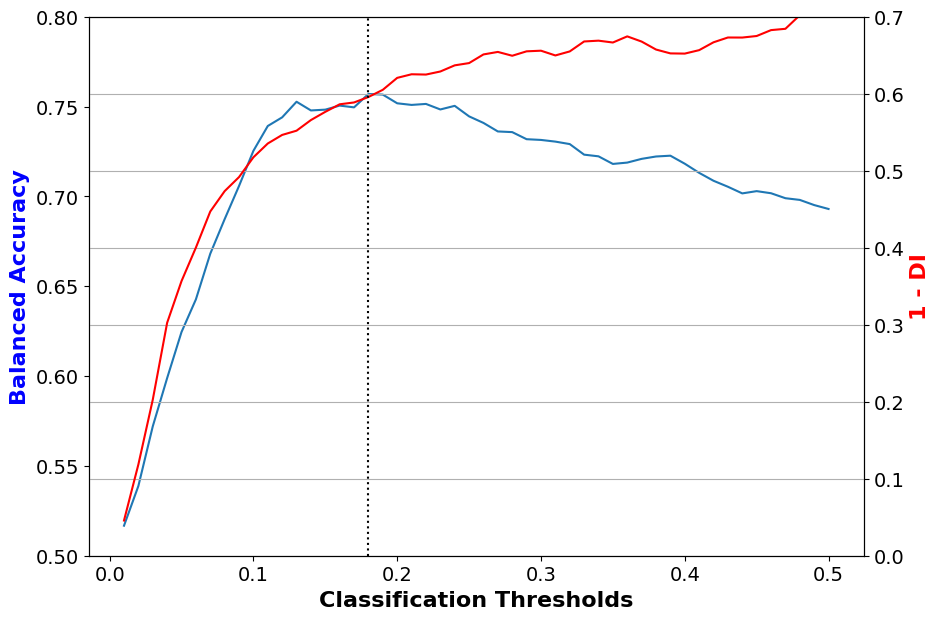

In [9]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - disp_imp
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - DI')

If you like, you can plot other metrics, e.g., average odds difference.

In the next cell, we write a function to print out a variety of other metrics. Since we look at 1 - disparate impact, **all of these metrics have a value of 0 if they are perfectly fair**. Again, you can learn more details about the various metrics in the [AIF360 documentation](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.ClassificationMetric.html#aif360.metrics.ClassificationMetric).

In [10]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    disp_imp_at_best_ind = 1 - metrics['disp_imp'][best_ind]
    print("\nCorresponding 1-DI value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7570

Corresponding 1-DI value: 0.5957
Corresponding average odds difference value: -0.1939
Corresponding statistical parity difference value: -0.2778
Corresponding equal opportunity difference value: -0.1528
Corresponding Theil index value: 0.0908


### Test the model
Now that we have used the validation data to select the best threshold, we will evaluate the test the model on the test data.

In [11]:
lr_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])
describe_metrics(lr_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7696

Corresponding 1-DI value: 0.5574
Corresponding average odds difference value: -0.1761
Corresponding statistical parity difference value: -0.2535
Corresponding equal opportunity difference value: -0.1598
Corresponding Theil index value: 0.0879


## Mitigate bias with in-processing
We will use reweighting as an in-processing step to try to increase fairness. AIF360 has a function that performs reweighting that we will use. If you're interested, you can look at details about how it works in [the documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html). 

If you look at the documentation, you will see that AIF360 classifies reweighting as a preprocessing, not an in-processing intervention. Technically, AIF360's implementation modifies the dataset, not the learning algorithm so it is pre-processing. But, it is functionally equivalent to modifying the learning algorithm's loss function, so we follow the convention of the fair ML field and call it in-processing.

In [35]:
# Reweighting is a AIF360 class to reweight the data 
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

We'll also define metrics for the reweighted data and print out the disparate impact of the dataset.

In [36]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


Then, we'll train a model, validate it, and evaluate of the test data.

In [37]:
# train
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)


In [38]:
# validate
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

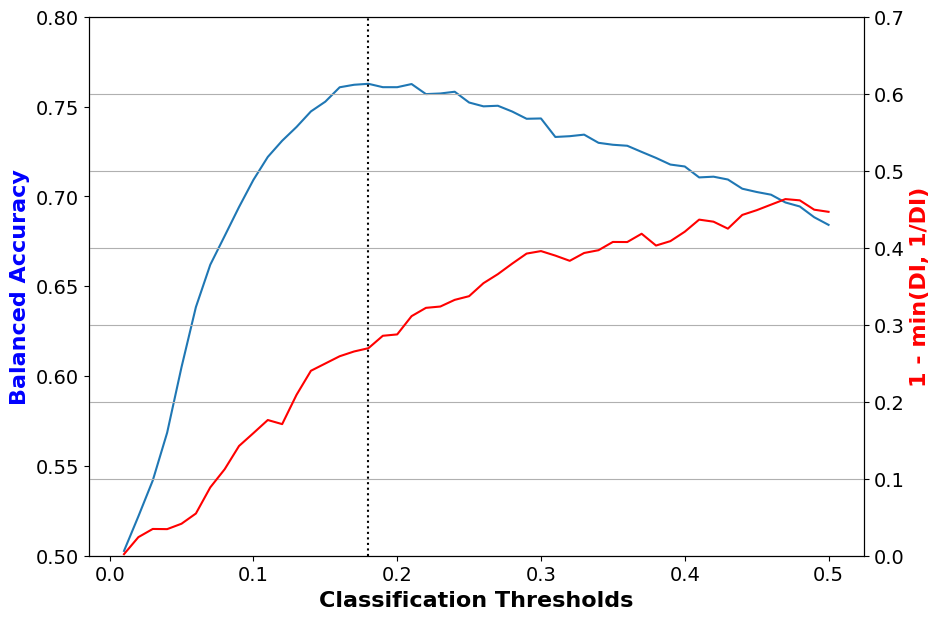

In [39]:
# plot validation results
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

In [40]:
# describe validation results
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7627

Corresponding 1-DI value: 0.2695
Corresponding average odds difference value: 0.0091
Corresponding statistical parity difference value: -0.1048
Corresponding equal opportunity difference value: 0.0538
Corresponding Theil index value: 0.0889


In [41]:
# Test
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7594

Corresponding 1-DI value: 0.2628
Corresponding average odds difference value: -0.0602
Corresponding statistical parity difference value: -0.1076
Corresponding equal opportunity difference value: -0.0680
Corresponding Theil index value: 0.0913


## Mitigate bias with post-processing
Since we have been focusing on equalized odds as the target fairness metric, we will focus on the [calibrated equalized odds](https://proceedings.neurips.cc/paper/2017/hash/b8b9c74ac526fffbeb2d39ab038d1cd7-Abstract.html) postprocessing technique that aims to have good equalized odds fairness while maintaining the calibration of the model. Again, we will use the [AIF360 implementation](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.CalibratedEqOddsPostprocessing.html) of this method.